# Conceptrol on SD + IP-Adapter

In [1]:
import os
from PIL import Image
import torch

from ip_adapter import ConceptrolIPAdapterPlus, IPAdapterPlus
from ip_adapter.custom_pipelines import StableDiffusionCustomPipeline

In [2]:
def image_grid(imgs, rows, cols, res=256):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    h_res = int(res * h / w)
    grid = Image.new('RGB', size=(cols*res, rows*h_res))

    for i, img in enumerate(imgs):
        grid.paste(img.resize((res, h_res)), box=(i%cols*res, i//cols*h_res))
    return grid

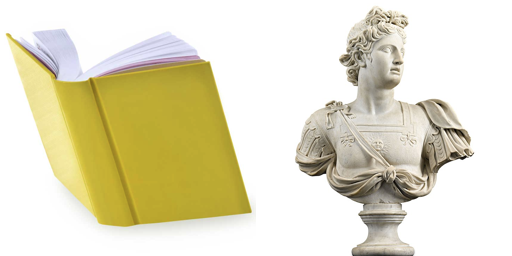

In [3]:
book_image = Image.open("demo/book.jpg")
statue_image = Image.open("demo/statue.jpg")

image_grid([book_image, statue_image], 1, 2)

In [4]:
base_model_path = "SG161222/Realistic_Vision_V5.1_noVAE"
ip_adapter_path = "../human-centric-adapter/models/ip-adapter-plus_sd15.bin"
image_encoder_path = "../human-centric-adapter/models/image_encoder/"
device = "cuda"

## Baseline

In [5]:
pipe = StableDiffusionCustomPipeline.from_pretrained(
    base_model_path,
    torch_dtype=torch.float16,
    feature_extractor=None,
    safety_checker=None
)
ip_pipe = IPAdapterPlus(pipe, image_encoder_path, ip_adapter_path, device, num_tokens=16)

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

/home/qiyuan/Conceptrol/ip_adapter/ip_adapter.py:155: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(self.ip_ckpt, map_location="cpu")


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Left to Right: [Reference of Book, Reference of Statue, Use Book, Use Statue, Use Book and Statue]


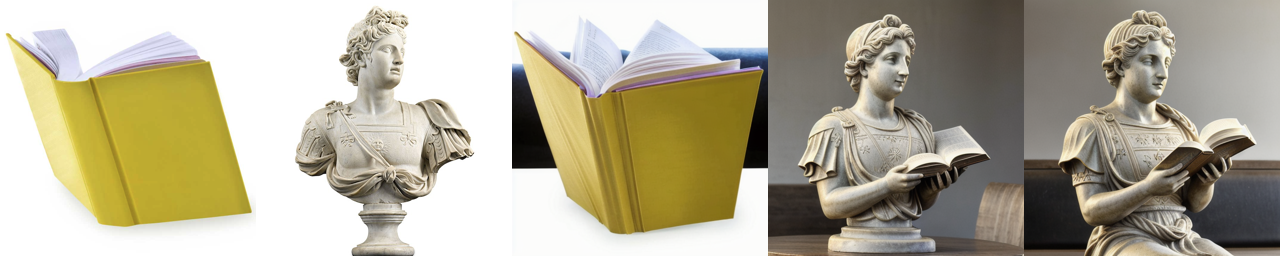

In [6]:
prompt = "A statue is reading the book in the cafe, best quality, high quality"
negative_prompt = "deformed, ugly, wrong proportion, low res, bad anatomy, worst quality, low quality"

images = [book_image]
concepts = ["the book"]

ip_book = ip_pipe.generate(prompt=prompt, pil_images=images, subjects=concepts, num_samples=1, num_inference_steps=50,
                            scale=0.6, negative_prompt=negative_prompt, control_guidance_start=0.0, seed=42)

images = [statue_image]
concepts = ["a statue"]

ip_statue = ip_pipe.generate(prompt=prompt, pil_images=images, subjects=concepts, num_samples=1, num_inference_steps=50,
                            scale=0.6, negative_prompt=negative_prompt, control_guidance_start=0.0, seed=42)

images = [book_image, statue_image]
concepts = ["the book", "a statue"]

ip_compositional = ip_pipe.generate(prompt=prompt, pil_images=images, subjects=concepts, num_samples=1, num_inference_steps=50,
                            scale=0.6, negative_prompt=negative_prompt, control_guidance_start=0.0, seed=42)

print("Left to Right: [Reference of Book, Reference of Statue, Use Book, Use Statue, Use Book and Statue]")
ip_results = image_grid([book_image, statue_image, ip_book[0], ip_statue[0], ip_compositional[0]], 1, 5)
ip_results

## Conceptrol

In [7]:
pipe = StableDiffusionCustomPipeline.from_pretrained(
    base_model_path,
    torch_dtype=torch.float16,
    feature_extractor=None,
    safety_checker=None
)
conceptrol_pipe = ConceptrolIPAdapterPlus(pipe, image_encoder_path, ip_adapter_path, device, num_tokens=16, global_masking=True, adaptive_scale_mask=False)

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

/home/qiyuan/Conceptrol/ip_adapter/ip_adapter.py:365: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(self.ip_ckpt, map_location="cpu")


Locate: the book 5 6


  0%|          | 0/50 [00:00<?, ?it/s]

Locate: a statue 1 2


  0%|          | 0/50 [00:00<?, ?it/s]

Locate: the book 5 6
Locate: a statue 1 2


  0%|          | 0/50 [00:00<?, ?it/s]

Left to Right: [Reference of Book, Reference of Statue, Use Book, Use Statue, Use Book and Statue]


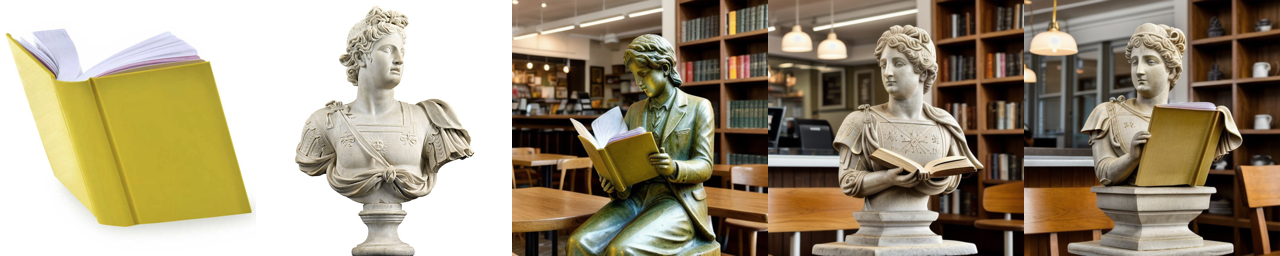

In [8]:
prompt = "A statue is reading the book in the cafe, best quality, high quality"
negative_prompt = "deformed, ugly, wrong proportion, low res, bad anatomy, worst quality, low quality"

images = [book_image]
concepts = ["the book"]

conceptrol_book = conceptrol_pipe.generate(prompt=prompt, pil_images=images, subjects=concepts, num_samples=1, num_inference_steps=50,
                            scale=1.5, negative_prompt=negative_prompt, control_guidance_start=0.2, seed=42)

images = [statue_image]
concepts = ["a statue"]

conceptrol_statue = conceptrol_pipe.generate(prompt=prompt, pil_images=images, subjects=concepts, num_samples=1, num_inference_steps=50,
                            scale=1.5, negative_prompt=negative_prompt, control_guidance_start=0.2, seed=42)

images = [book_image, statue_image]
concepts = ["the book", "a statue"]

conceptrol_compositional = conceptrol_pipe.generate(prompt=prompt, pil_images=images, subjects=concepts, num_samples=1, num_inference_steps=50,
                            scale=1.5, negative_prompt=negative_prompt, control_guidance_start=0.2, seed=42)

print("Left to Right: [Reference of Book, Reference of Statue, Use Book, Use Statue, Use Book and Statue]")
conceptrol_results = image_grid([book_image, statue_image, conceptrol_book[0], conceptrol_statue[0], conceptrol_compositional[0]], 1, 5)
conceptrol_results

## Comparison

Comparison of all, Top: wo/Conceptrol; Bottom: w/Conceptrol


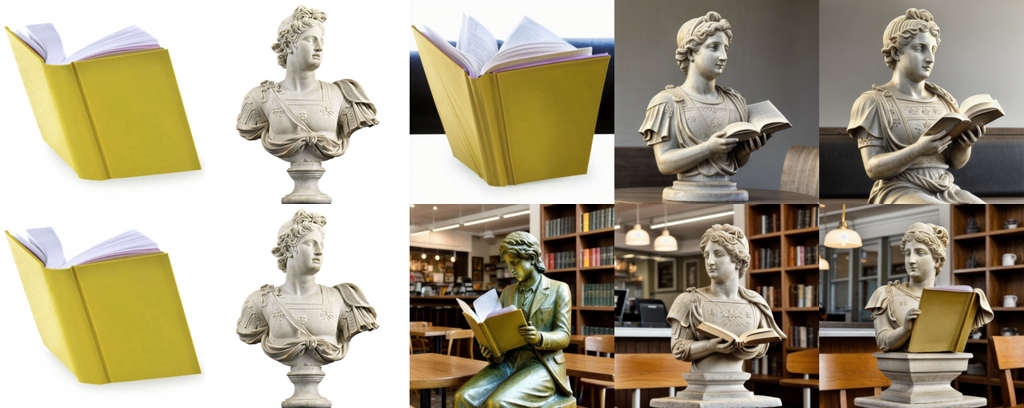

In [10]:
print("Comparison of all, Top: wo/Conceptrol; Bottom: w/Conceptrol")

results_all = image_grid([ip_results, conceptrol_results], 2, 1, res=1024)
results_all